# Learned convolution filters for image denoising

Filtering, i.e. convolving an image with a pre-defined convolution kernel (such as a mean filter or a gaussian filter) is a common practice for image denoising. However finding the best filter, or the best filter parameters (such as the variance in gaussian filters) can be difficult to do by hand. In this notebook we show how we can _learn_ the optimal filter, on a training set. We first show how to learn the optimal parameter in a gaussian filter. We then learn an optimal filter of a given size, without the constraint of being gaussian.

## 1) Data preparation

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

import utils
import utils.data, utils.ML, utils.models

In [2]:
plt.rcParams["figure.figsize"] = [4.3, 3]
torch.manual_seed(0)

device = "cpu"

In [3]:
# Download train and test data:

training_data_ = datasets.MNIST(
    root="/Users/lucas/Documents/Data/",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data_ = datasets.MNIST(
    root="/Users/lucas/Documents/Data/",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_split, val_split = torch.utils.data.random_split(training_data_, [50000, 10000], generator=torch.Generator().manual_seed(42))

In [4]:
# Create noisy dataset:

class NoisyData(Dataset):
    
    def __init__(self, data_split, sigma):
        
        self.data_split = data_split
        self.sigma = sigma  # noise level
        
    def __len__(self):
        return len(self.data_split)
    
    def __getitem__(self, idx):
        
        clean_image = self.data_split[idx][0]
        
        noise = self.sigma * torch.randn_like(clean_image)
        
        noisy_image = clean_image + noise
        noisy_image[noisy_image>1.0] = 1.0
        noisy_image[noisy_image<0.0] = 0.0
        
        return noisy_image, clean_image

In [5]:
sigma = 0.2

train_data = NoisyData(train_split, sigma)
val_data = NoisyData(val_split, sigma)
test_data = NoisyData(test_data_, sigma)

batch_size = 128

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

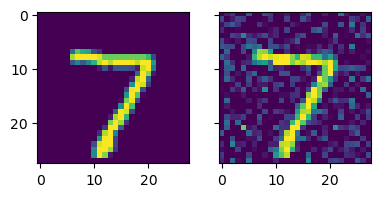

In [9]:
Y, X = next(iter(test_dataloader))  # noisy, clean

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].imshow(X[0, 0])
ax[1].imshow(Y[0, 0])

## 2) Denoising using hand-crafted filters

A 1D gaussian filter is of the form $[\alpha, 1, \alpha]$, with $0 \leq \alpha \leq 1$. A 2D gaussian filter is equivalent to applying a 1D filter in both dimensions, which correspond to a 2D kernel:  
$$
\begin{bmatrix}
&\alpha^2 &\alpha &\alpha^2\\    
&\alpha  &1 &\alpha\\
&\alpha^2 &\alpha &\alpha^2 
\end{bmatrix}
$$

For simplicity we only consider 3x3 kernels. Note that the parameter $\alpha$ is a proxy for the _variance_ of the kernel. A large variance (large $\alpha$) means that each pixel will be averaged with its neighboring pixels with a large weight. In the extreme case $\alpha = 1$, the kernel corresponds to a moving average. When $\alpha = 0$, the filter is just an identity operation which leaves the image unchanged. Also note that the kernel is often normalized (to unit sum) in order to preserve the overall image energy.  

In this section we look at image filtering with different values of the parameter $\alpha$:

In [42]:
def gaussian_kernel(alpha):
    ''' Generate 2D kernel with parameter alpha'''
    kernel_1D = torch.tensor([alpha, 1, alpha])
    kernel_2D = torch.outer(kernel_1D, kernel_1D)
    kernel_2D = kernel_2D/torch.sum(kernel_2D)  # normalize
    kernel_2D = kernel_2D[None, None, :]  # add extra dimensions
    
    return kernel_2D

In [46]:
alpha = 0.5

kernel_gaussian = gaussian_kernel(alpha)

print(kernel_gaussian)

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


In [30]:
def filter_batch(Y, kernel):
    ''' Filter a batch of images Y using given kernel '''
    Y_filtered = F.conv2d(Y, kernel, bias=None, padding='same')
    
    return Y_filtered

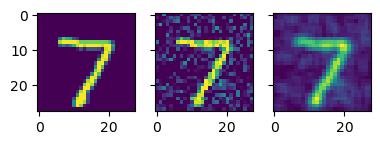

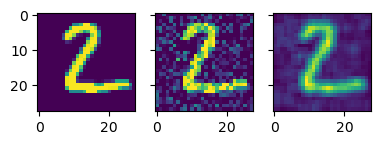

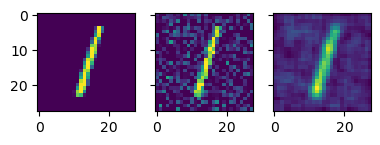

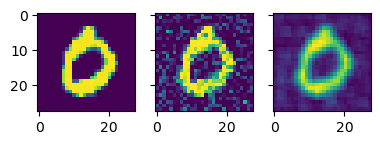

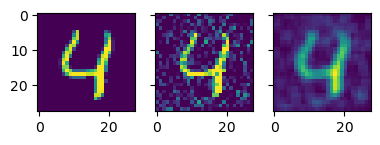

In [45]:
# Plot a few examples:

Y, X = next(iter(test_dataloader))

Y_filtered = filter_batch(Y, kernel_gaussian)

for i in range(5):
    
    fig, ax = plt.subplots(1, 3, sharey=True)
    ax[0].imshow(X[i, 0])  # clean
    ax[1].imshow(Y[i, 0])  # noisy
    ax[2].imshow(Y_filtered[i, 0])  # filtered

We can see that the gaussian filter is doing a good job at removing the noise, however tends to blur out the image. Large $\alpha$ generally tends to reduce more noise but blur the image. We can evaluate the resulting denoising filter in terms of Signal-to-Noise ratio (SNR):

In [34]:
def calculate_SNR(dataloader, filter_func):
    ''' Calculate average per-batch SNR, given a data loader
        and a filtering function. '''
    num_batches = 0
    SNR_in, SNR_out = 0, 0

    for Y, X in dataloader:

        filtered_batch = filter_func(Y)

        SNR_in += 10 * torch.log10(torch.sum(X**2)/torch.sum((Y-X)**2))
        SNR_out += 10 * torch.log10(torch.sum(X**2)/torch.sum((filtered_batch-X)**2))

        num_batches += 1

    SNR_in/=num_batches
    SNR_out/=num_batches
    
    return SNR_in, SNR_out

In [55]:
SNR_in, SNR_out = calculate_SNR(test_dataloader, lambda Y: filter_batch(Y, kernel_gaussian))

print(f"Gaussian filter with alpha = {alpha:.2f}:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

Gaussian filter with alpha = 0.20:
Input SNR:  7.267 dB
Output SNR: 8.282 dB


In [57]:
# Average filter:

alpha = 1.0
average_kernel = gaussian_kernel(alpha=alpha)

SNR_in, SNR_out = calculate_SNR(test_dataloader, lambda Y: filter_batch(Y, average_kernel))

print(f"Gaussian filter with alpha = {alpha:.2f}:")
print(f"SNR_in:  {SNR_in:.3f} dB")
print(f"SNR_out: {SNR_out:.3f} dB")

Gaussian filter with alpha = 1.00:
SNR_in:  7.280 dB
SNR_out: 7.391 dB


## 2) Learn optimal gaussian filter

Manually finding the optimal parameter $\alpha$ can be difficult. Here we show how the optimal $\alpha$ parameter can be learned on a training set, using Pytorch.

In [47]:
def make_diff_kernel(alpha_tensor):
    ''' Make a differentiable kernel, parametrized by alpha, 
        that can be learned with Pytorch.
        Each step of this function are differentiable layers in pytorch.
        The input alpha_tensor should be a differentiable pytorch tensor, e.g.:
        > alpha_tensor = torch.tensor([0.5], requires_grad=True)
        '''
    kernel_1D = torch.hstack((alpha_tensor, torch.tensor([1]), alpha_tensor))
    kernel_2D = torch.outer(kernel_1D, kernel_1D)
    kernel_2D = kernel_2D/torch.sum(kernel_2D)
    kernel_2D = kernel_2D[None, None, :]
    
    return kernel_2D

In [65]:
# Training

alpha = 0.5  # inital alpha parameter, in float
alpha_tensor = torch.tensor([alpha], requires_grad=True)  # convert to tensor to make it differentiable

optimizer = torch.optim.SGD([alpha_tensor], lr=1e-1)
loss_fn = nn.MSELoss()

for i_epoch in range(2):

    for i_batch, (Y, X) in enumerate(train_dataloader):

        # forward:
        kernel = make_diff_kernel(alpha_tensor)
        filtered_batch = filter_batch(Y, kernel)

        loss = loss_fn(filtered_batch, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i_batch % 50 == 0:
            print(f'epoch {i_epoch+1} - batch {i_batch:<3} - alpha: {alpha_tensor.item():.5f} - loss = {loss.item():.5f}')
                
alpha_learned = alpha_tensor.item()

epoch 0 - batch 0   - alpha: 0.49905 - loss = 0.01694
epoch 0 - batch 50  - alpha: 0.44983 - loss = 0.01653
epoch 0 - batch 100 - alpha: 0.40065 - loss = 0.01593
epoch 0 - batch 150 - alpha: 0.35327 - loss = 0.01608
epoch 0 - batch 200 - alpha: 0.30985 - loss = 0.01497
epoch 0 - batch 250 - alpha: 0.27211 - loss = 0.01472
epoch 0 - batch 300 - alpha: 0.24281 - loss = 0.01467
epoch 0 - batch 350 - alpha: 0.22289 - loss = 0.01469
epoch 1 - batch 0   - alpha: 0.21240 - loss = 0.01455
epoch 1 - batch 50  - alpha: 0.20404 - loss = 0.01468
epoch 1 - batch 100 - alpha: 0.19960 - loss = 0.01479
epoch 1 - batch 150 - alpha: 0.19753 - loss = 0.01471
epoch 1 - batch 200 - alpha: 0.19680 - loss = 0.01461
epoch 1 - batch 250 - alpha: 0.19610 - loss = 0.01439
epoch 1 - batch 300 - alpha: 0.19512 - loss = 0.01444
epoch 1 - batch 350 - alpha: 0.19502 - loss = 0.01476


In [66]:
learned_gaussian_kernel = gaussian_kernel(alpha=alpha_learned)

print(f"Gaussian filter with learned alpha = {alpha_learned:.3f}:")

SNR_in, SNR_out = calculate_SNR(train_dataloader, lambda Y: filter_batch(Y, learned_gaussian_kernel))
print("\nSNR on train set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

SNR_in, SNR_out = calculate_SNR(test_dataloader, lambda Y: filter_batch(Y, learned_gaussian_kernel))
print("\nSNR on test set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

Gaussian filter with learned alpha = 0.195:

 SNR on train set:
Input SNR:  7.229 dB
Output SNR: 8.872 dB

 SNR on test set:
Input SNR:  7.268 dB
Output SNR: 8.925 dB


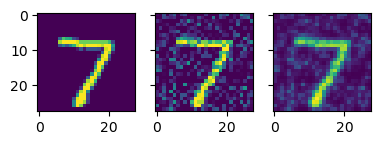

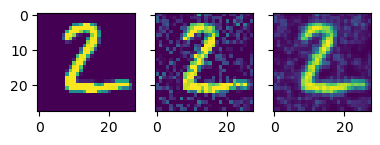

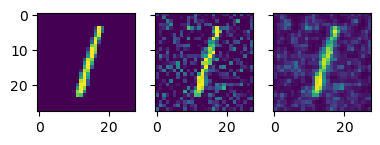

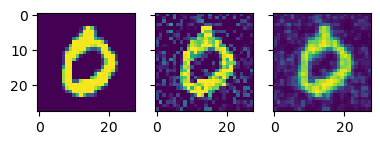

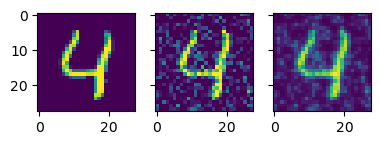

In [67]:
# Let's visualize a few examples:

Y, X = next(iter(test_dataloader))

Y_filtered = filter_batch(Y, learned_gaussian_kernel)

for i in range(5):
    
    fig, ax = plt.subplots(1, 3, sharey=True)
    ax[0].imshow(X[i, 0])  # clean
    ax[1].imshow(Y[i, 0])  # noisy
    ax[2].imshow(Y_filtered[i, 0])  # filtered

Learning the optimal parameter in gaussian filters leads to better SNR results than manually tuning the parameter - or at least helps us find the optimal parameter in a data-driven way. But can we do better than Gaussian filters? Again, manually choosing the best type of filter can be a difficult task. In the next section we show how to learn the overall best 3x3 filter. 

## 3) Learning the optimal convolution filter

### 3.1) 3x3 filters

In [102]:
# Training

learned_kernel = torch.rand((1, 1, 3, 3), requires_grad=True)

optimizer = torch.optim.SGD([learned_kernel], lr=1e-1)

for i_epoch in range(2):

    for i_batch, (Y, X) in enumerate(train_dataloader):

        # forward:
        conv_image = filter_batch(Y, learned_kernel)

        loss = loss_fn(conv_image, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i_batch % 50 == 0:
            print(f'epoch {i_epoch+1} - batch {i_batch:<3} - loss = {loss.item():.5f}')
        
learned_kernel = learned_kernel.detach()

epoch 1 - batch 0   - loss = 0.76320
epoch 1 - batch 50  - loss = 0.02555
epoch 1 - batch 100 - loss = 0.02137
epoch 1 - batch 150 - loss = 0.01885
epoch 1 - batch 200 - loss = 0.01656
epoch 1 - batch 250 - loss = 0.01571
epoch 1 - batch 300 - loss = 0.01522
epoch 1 - batch 350 - loss = 0.01471
epoch 2 - batch 0   - loss = 0.01456
epoch 2 - batch 50  - loss = 0.01431
epoch 2 - batch 100 - loss = 0.01449
epoch 2 - batch 150 - loss = 0.01441
epoch 2 - batch 200 - loss = 0.01405
epoch 2 - batch 250 - loss = 0.01389
epoch 2 - batch 300 - loss = 0.01397
epoch 2 - batch 350 - loss = 0.01408


Learned kernel:
tensor([[[[-0.0489,  0.1244,  0.0390],
          [ 0.1295,  0.5059,  0.1257],
          [ 0.0359,  0.1258, -0.0472]]]])


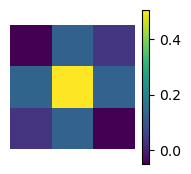

In [103]:
print("Learned kernel:")
print(learned_kernel)

plt.figure(figsize=(2, 2))
plt.imshow(torch.squeeze(learned_kernel))
plt.colorbar()
plt.axis('off');

In [104]:
print(f"Learned 3x3 filter:")

SNR_in, SNR_out = calculate_SNR(train_dataloader, lambda Y: filter_batch(Y, learned_kernel))
print("\nSNR on train set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

SNR_in, SNR_out = calculate_SNR(test_dataloader, lambda Y: filter_batch(Y, learned_kernel))
print("\nSNR on test set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

Learned filter:

SNR on train set:
Input SNR:  7.224 dB
Output SNR: 9.007 dB

SNR on test set:
Input SNR:  7.271 dB
Output SNR: 9.057 dB


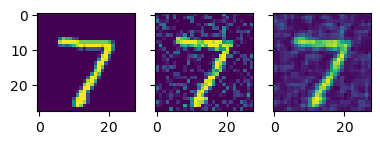

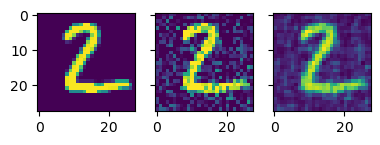

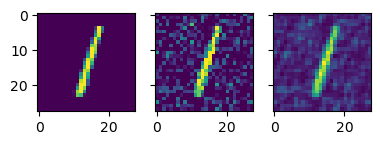

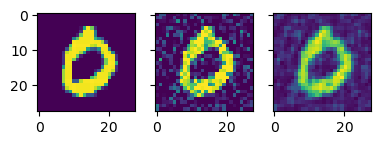

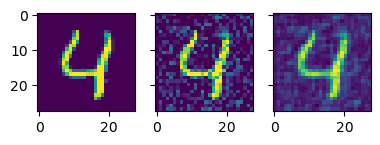

In [89]:
# Let's visualize a few examples:

Y, X = next(iter(test_dataloader))

Y_filtered = filter_batch(Y, learned_kernel)

for i in range(5):
    
    fig, ax = plt.subplots(1, 3, sharey=True)
    ax[0].imshow(X[i, 0])  # clean
    ax[1].imshow(Y[i, 0])  # noisy
    ax[2].imshow(Y_filtered[i, 0])  # filtered

Interestingly, the learned kernel looks similar to a gaussian kernel. In fact, regardless of the initalization (with a random kernel or a mean average), the training algorithm converges to a kernel that is gaussian-like. This shows empirically why gaussian kernels have been so popular for denoising tasks. However the learned kernel is not _exactly_ gaussian, and the small differences lead to a performance improvement compared to a strictly gaussian kernel.  

We can also try with larger kernels, e.g. 5x5:

### 3.1) 5x5 filters

In [116]:
# Training

learned_kernel = torch.rand((1, 1, 5, 5), requires_grad=True)

optimizer = torch.optim.SGD([learned_kernel], lr=1e-1)

for i_epoch in range(2):

    for i_batch, (Y, X) in enumerate(train_dataloader):

        # forward:
        conv_image = filter_batch(Y, learned_kernel)

        loss = loss_fn(conv_image, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i_batch % 50 == 0:
            print(f'epoch {i_epoch+1} - batch {i_batch:<3} - loss = {loss.item():.5f}')
        
learned_kernel = learned_kernel.detach()

epoch 1 - batch 0   - loss = 7.80862
epoch 1 - batch 50  - loss = 0.03994
epoch 1 - batch 100 - loss = 0.02462
epoch 1 - batch 150 - loss = 0.01924
epoch 1 - batch 200 - loss = 0.01610
epoch 1 - batch 250 - loss = 0.01453
epoch 1 - batch 300 - loss = 0.01383
epoch 1 - batch 350 - loss = 0.01329
epoch 2 - batch 0   - loss = 0.01280
epoch 2 - batch 50  - loss = 0.01265
epoch 2 - batch 100 - loss = 0.01244
epoch 2 - batch 150 - loss = 0.01271
epoch 2 - batch 200 - loss = 0.01223
epoch 2 - batch 250 - loss = 0.01225
epoch 2 - batch 300 - loss = 0.01226
epoch 2 - batch 350 - loss = 0.01226


Learned kernel:
tensor([[[[-0.0475, -0.0088, -0.0314,  0.0016, -0.0492],
          [-0.0382,  0.0257,  0.1549,  0.0833, -0.0197],
          [ 0.0025,  0.1683,  0.4509,  0.1662, -0.0222],
          [-0.0372,  0.0813,  0.1543,  0.0318, -0.0186],
          [-0.0390, -0.0064, -0.0180, -0.0284, -0.0472]]]])


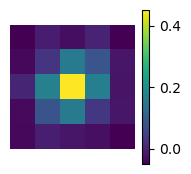

In [117]:
print("Learned kernel:")
print(learned_kernel)

plt.figure(figsize=(2, 2))
plt.imshow(torch.squeeze(learned_kernel))
plt.colorbar()
plt.axis('off');

In [120]:
print(f"Learned 5x5 filter:")

SNR_in, SNR_out = calculate_SNR(train_dataloader, lambda Y: filter_batch(Y, learned_kernel))
print("\nSNR on train set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

SNR_in, SNR_out = calculate_SNR(test_dataloader, lambda Y: filter_batch(Y, learned_kernel))
print("\nSNR on test set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

Learned 5x5 filter:

SNR on train set:
Input SNR:  7.225 dB
Output SNR: 9.636 dB

SNR on test set:
Input SNR:  7.262 dB
Output SNR: 9.677 dB


The learned 5x5 filter also look somewhat gaussian, and leads to even better results. 7x7 and 9x9 filters also seem to lead to some further improvement, but beyond that we might run into boundary issues.  

## 4) Going deeper and wider:

We have so far restricted ourselves to convolving with a single kernel. However, the recent successes of deep learning and convolutional neural networks (CNN) have shown that one can get far better results, by using deeper (sequentially applying convolutions) or wider (learning multiple kernels at once) architectures.  

In this section we investigate different architectures, going beyond the single kernel learning.

We start with a sequence of 3x3 filters applied one after the other. Since a convolution is a linear operator, sequentially applying 2 convolutions one after the other would be equivalent to convolving once with a (larger) kernel. To overcome that, we also add a non-linear (ReLU) activation function. In addition, instead of learning a single convolution kernel at the first layer, we learn 3 convolution kernels, resulting in 3 hidden filtered images (i.e. an image of depth 3). Those 3 images are then combined into 1 using a 2D convolution going from depth 3 back to depth 1, which is in fact a 3D convolution using a 3D kernel (with no padding in the depth dimension).

In [156]:
class sequential_filters(nn.Module):
    
    def __init__(self):
        super(sequential_filters, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 3, (3, 3), padding='same', bias=None)
        self.conv2 = nn.Conv2d(3, 1, (3, 3), padding='same', bias=None)
          
    def forward(self, x):
        h = F.relu(self.conv1(x))
        x = self.conv2(h)
        return x, h
        

In [157]:
# Training

model = sequential_filters()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i_epoch in range(3):

    for i_batch, (Y, X) in enumerate(train_dataloader):

        # forward:
        conv_image, h = model(Y)

        loss = loss_fn(conv_image, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i_batch % 50 == 0:
            print(f'epoch {i_epoch+1} - batch {i_batch:<3} - loss = {loss.item():.5f}')

epoch 1 - batch 0   - loss = 0.14729
epoch 1 - batch 50  - loss = 0.09830
epoch 1 - batch 100 - loss = 0.03836
epoch 1 - batch 150 - loss = 0.02544
epoch 1 - batch 200 - loss = 0.01975
epoch 1 - batch 250 - loss = 0.01781
epoch 1 - batch 300 - loss = 0.01661
epoch 1 - batch 350 - loss = 0.01561
epoch 2 - batch 0   - loss = 0.01416
epoch 2 - batch 50  - loss = 0.01115
epoch 2 - batch 100 - loss = 0.00969
epoch 2 - batch 150 - loss = 0.00934
epoch 2 - batch 200 - loss = 0.00830
epoch 2 - batch 250 - loss = 0.00812
epoch 2 - batch 300 - loss = 0.00802
epoch 2 - batch 350 - loss = 0.00815
epoch 3 - batch 0   - loss = 0.00793
epoch 3 - batch 50  - loss = 0.00794
epoch 3 - batch 100 - loss = 0.00791
epoch 3 - batch 150 - loss = 0.00798
epoch 3 - batch 200 - loss = 0.00736
epoch 3 - batch 250 - loss = 0.00725
epoch 3 - batch 300 - loss = 0.00735
epoch 3 - batch 350 - loss = 0.00729


In [158]:
model.eval()

SNR_in, SNR_out = calculate_SNR(train_dataloader, lambda Y: model(Y)[0])
print("\nSNR on train set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

SNR_in, SNR_out = calculate_SNR(test_dataloader, lambda Y: model(Y)[0])
print("\nSNR on test set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")


SNR on train set:
Input SNR:  7.224 dB
Output SNR: 11.929 dB

SNR on test set:
Input SNR:  7.273 dB
Output SNR: 12.009 dB


This model leads to a significant performance improvement! Let's visualize the output as well as the hidden units to see what is happenning:

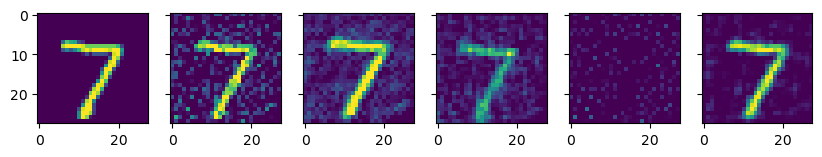

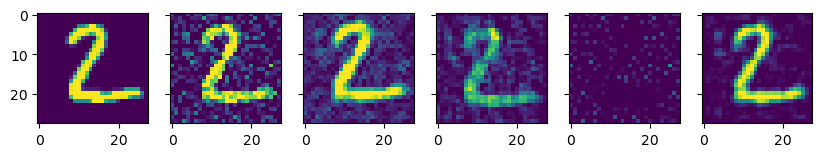

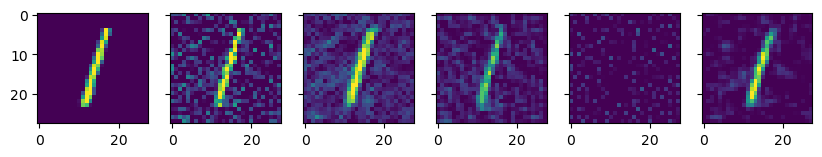

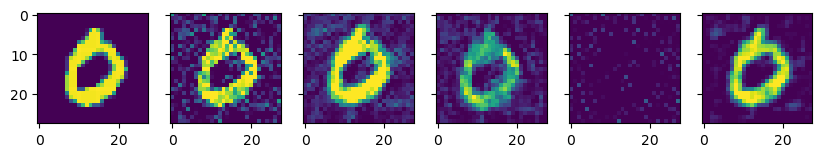

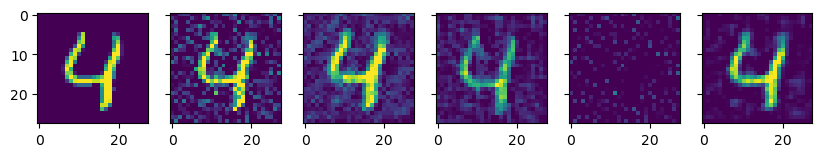

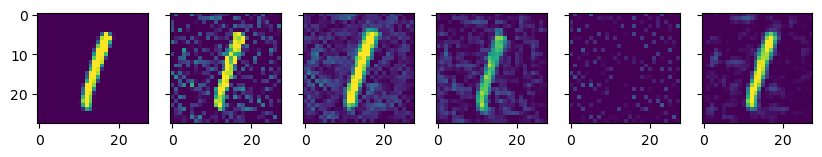

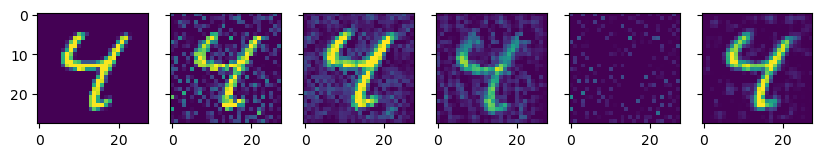

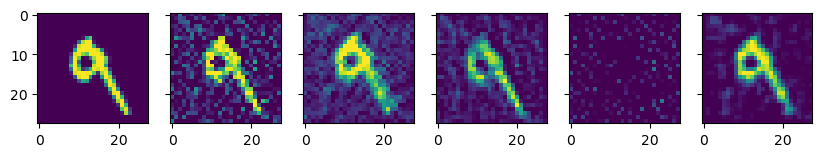

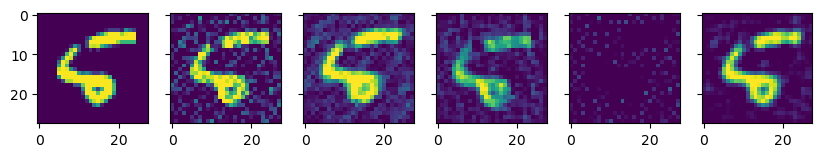

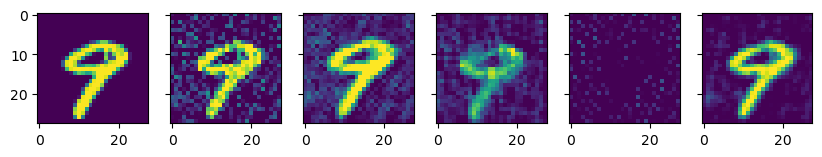

In [176]:
Y, X = next(iter(test_dataloader))

conv_image, hidden = model(Y)

conv_image = conv_image.detach()
hidden = hidden.detach()

for i in range(10):
    
    fig, ax = plt.subplots(1, 6, figsize=(10,5), sharey=True)
    ax[0].imshow(X[i, 0], vmin=0, vmax=1)  # clean
    ax[1].imshow(Y[i, 0], vmin=0, vmax=1)  # noisy
    
    ax[2].imshow(hidden[i, 0], vmin=0, vmax=1)  # hidden 1
    ax[3].imshow(hidden[i, 1], vmin=0, vmax=1)  # hidden 2
    ax[4].imshow(hidden[i, 2], vmin=0, vmax=1)  # hidden 3
    
    ax[5].imshow(conv_image[i, 0], vmin=0, vmax=1)  # denoised

We can see how the first layer is doing 3 separate convolutions using 3 different kernels. The second then combines those 3 outputs to give the denoised output.  

The 3rd filter in the first layer exhibits an interesting behaviour. It seems to be keeping (some of the noise), while completely removing the written digits! To see how the network is doing that, we can have a look at the kernels learned in the first layer:

In [180]:
kernel1 = model.conv1.weight.detach()

print(kernel1)

tensor([[[[-0.3701,  0.1825,  0.1170],
          [ 0.2130,  0.1185,  0.3481],
          [ 0.1865,  0.3775,  0.1069]]],


        [[[ 0.0778,  0.2360,  0.3590],
          [-0.0353, -0.0568,  0.1766],
          [-0.2105, -0.0883,  0.3127]]],


        [[[ 0.0935, -0.2204, -0.2007],
          [-0.4044,  0.6508, -0.0617],
          [-0.0231, -0.1198, -0.1766]]]])


As can be seen the filter has a high value in the centre, and almost only negative values around. Which means that if a pixel is surrounded by high-intensity pixels (which is the case for digit strokes), the resulting convolution will tend to return a negative value for that pixel. On the contrary, noisy isolated pixels are more likely to be sourrounded by zero-intensity pixels which leaves them unaffected by that filter. After the ReLU activation function, the (negative) pixels corresponding to brush strokes are then zero-ed out, which gives the resulting image. We can then imagine how this output image which contains only noise could be subtracted from the noisy input, to remove the noise component. This is indeed what the next filter seems to be doing, since the coefficients corresponding to the 3rd depth dimension are all negative:

In [182]:
kernel2 = model.conv2.weight.detach()

print(kernel2)

tensor([[[[ 0.0379,  0.2319,  0.0503],
          [ 0.0236,  0.2665,  0.1015],
          [ 0.0682, -0.0071, -0.2421]],

         [[ 0.1169, -0.0700, -0.1982],
          [ 0.1697, -0.1133, -0.0082],
          [ 0.2645,  0.1622,  0.1085]],

         [[-0.0650, -0.3114, -0.3471],
          [-0.4002, -0.7069, -0.3763],
          [-0.1967, -0.4284, -0.1714]]]])


## 5) Experiments with different architectures

In this section we experiment with different architectures, for example adding more layers, more depth, or both.

In [190]:
class sequential_filters_2(nn.Module):
    
    def __init__(self):
        super(sequential_filters_2, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 3, (3, 3), padding='same', bias=None)
        self.conv2 = nn.Conv2d(3, 3, (3, 3), padding='same', bias=None)
        self.conv3 = nn.Conv2d(3, 1, (3, 3), padding='same', bias=None)

          
    def forward(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(h1))
        x = self.conv3(h2)
        
        return x
    
print(f"Number of parameters: {sum(torch.numel(p) for p in sequential_filters_2().parameters())}")

number of parameters: 135


In [185]:
# Training

model = sequential_filters_2()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i_epoch in range(3):

    for i_batch, (Y, X) in enumerate(train_dataloader):

        # forward:
        conv_image = model(Y)

        loss = loss_fn(conv_image, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i_batch % 50 == 0:
            print(f'epoch {i_epoch+1} - batch {i_batch:<3} - loss = {loss.item():.5f}')

epoch 1 - batch 0   - loss = 0.11571
epoch 1 - batch 50  - loss = 0.04279
epoch 1 - batch 100 - loss = 0.02980
epoch 1 - batch 150 - loss = 0.02051
epoch 1 - batch 200 - loss = 0.01454
epoch 1 - batch 250 - loss = 0.01305
epoch 1 - batch 300 - loss = 0.01246
epoch 1 - batch 350 - loss = 0.01180
epoch 2 - batch 0   - loss = 0.01145
epoch 2 - batch 50  - loss = 0.01068
epoch 2 - batch 100 - loss = 0.01039
epoch 2 - batch 150 - loss = 0.00995
epoch 2 - batch 200 - loss = 0.00893
epoch 2 - batch 250 - loss = 0.00863
epoch 2 - batch 300 - loss = 0.00842
epoch 2 - batch 350 - loss = 0.00807
epoch 3 - batch 0   - loss = 0.00791
epoch 3 - batch 50  - loss = 0.00775
epoch 3 - batch 100 - loss = 0.00785
epoch 3 - batch 150 - loss = 0.00786
epoch 3 - batch 200 - loss = 0.00748
epoch 3 - batch 250 - loss = 0.00737
epoch 3 - batch 300 - loss = 0.00730
epoch 3 - batch 350 - loss = 0.00720


In [187]:
model.eval()

SNR_in, SNR_out = calculate_SNR(train_dataloader, model)
print("\nSNR on train set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

SNR_in, SNR_out = calculate_SNR(test_dataloader, model)
print("\nSNR on test set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")


SNR on train set:
Input SNR:  7.225 dB
Output SNR: 11.936 dB

SNR on test set:
Input SNR:  7.272 dB
Output SNR: 12.024 dB


In [197]:
class sequential_filters_3(nn.Module):
    
    def __init__(self):
        super(sequential_filters_3, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (3, 3), padding='same', bias=None)
        self.conv2 = nn.Conv2d(8, 1, (3, 3), padding='same', bias=None)

          
    def forward(self, x):
        h1 = F.relu(self.conv1(x))
        x = self.conv2(h1)
        
        return x
    
print(f"Number of parameters: {sum(torch.numel(p) for p in sequential_filters_3().parameters())}")

Number of parameters: 144


In [198]:
# Training

model = sequential_filters_2()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i_epoch in range(3):

    for i_batch, (Y, X) in enumerate(train_dataloader):

        # forward:
        conv_image = model(Y)

        loss = loss_fn(conv_image, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i_batch % 50 == 0:
            print(f'epoch {i_epoch+1} - batch {i_batch:<3} - loss = {loss.item():.5f}')

epoch 1 - batch 0   - loss = 0.13693
epoch 1 - batch 50  - loss = 0.05948
epoch 1 - batch 100 - loss = 0.02732
epoch 1 - batch 150 - loss = 0.01863
epoch 1 - batch 200 - loss = 0.01325
epoch 1 - batch 250 - loss = 0.01148
epoch 1 - batch 300 - loss = 0.01054
epoch 1 - batch 350 - loss = 0.00970
epoch 2 - batch 0   - loss = 0.00911
epoch 2 - batch 50  - loss = 0.00883
epoch 2 - batch 100 - loss = 0.00871
epoch 2 - batch 150 - loss = 0.00867
epoch 2 - batch 200 - loss = 0.00792
epoch 2 - batch 250 - loss = 0.00791
epoch 2 - batch 300 - loss = 0.00779
epoch 2 - batch 350 - loss = 0.00775
epoch 3 - batch 0   - loss = 0.00761
epoch 3 - batch 50  - loss = 0.00748
epoch 3 - batch 100 - loss = 0.00747
epoch 3 - batch 150 - loss = 0.00765
epoch 3 - batch 200 - loss = 0.00706
epoch 3 - batch 250 - loss = 0.00707
epoch 3 - batch 300 - loss = 0.00705
epoch 3 - batch 350 - loss = 0.00701


In [200]:
model.eval()

SNR_in, SNR_out = calculate_SNR(train_dataloader, model)
print("\nSNR on train set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

SNR_in, SNR_out = calculate_SNR(test_dataloader, model)
print("\nSNR on test set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")


SNR on train set:
Input SNR:  7.223 dB
Output SNR: 12.071 dB

SNR on test set:
Input SNR:  7.273 dB
Output SNR: 12.148 dB


In [207]:
class sequential_filters_4(nn.Module):
    
    def __init__(self):
        super(sequential_filters_4, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (3, 3), padding='same', bias=None)
        self.conv2 = nn.Conv2d(8, 16, (3, 3), padding='same', bias=None)
        self.conv3 = nn.Conv2d(16, 32, (3, 3), padding='same', bias=None)
        self.conv4 = nn.Conv2d(32, 1, (3, 3), padding='same', bias=None)

          
    def forward(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(h1))
        h3 = F.relu(self.conv3(h2))
        x = self.conv4(h3)
        
        return x
    
print(f"Number of parameters: {sum(torch.numel(p) for p in sequential_filters_4().parameters())}")

Number of parameters: 6120


In [208]:
# Training

model = sequential_filters_4()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i_epoch in range(3):

    for i_batch, (Y, X) in enumerate(train_dataloader):

        # forward:
        conv_image = model(Y)

        loss = loss_fn(conv_image, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i_batch % 50 == 0:
            print(f'epoch {i_epoch+1} - batch {i_batch:<3} - loss = {loss.item():.5f}')

epoch 1 - batch 0   - loss = 0.10812
epoch 1 - batch 50  - loss = 0.01064
epoch 1 - batch 100 - loss = 0.00734
epoch 1 - batch 150 - loss = 0.00623
epoch 1 - batch 200 - loss = 0.00512
epoch 1 - batch 250 - loss = 0.00470
epoch 1 - batch 300 - loss = 0.00440
epoch 1 - batch 350 - loss = 0.00425
epoch 2 - batch 0   - loss = 0.00404
epoch 2 - batch 50  - loss = 0.00402
epoch 2 - batch 100 - loss = 0.00394
epoch 2 - batch 150 - loss = 0.00389
epoch 2 - batch 200 - loss = 0.00345
epoch 2 - batch 250 - loss = 0.00366
epoch 2 - batch 300 - loss = 0.00370
epoch 2 - batch 350 - loss = 0.00350
epoch 3 - batch 0   - loss = 0.00344
epoch 3 - batch 50  - loss = 0.00338
epoch 3 - batch 100 - loss = 0.00346
epoch 3 - batch 150 - loss = 0.00357
epoch 3 - batch 200 - loss = 0.00316
epoch 3 - batch 250 - loss = 0.00320
epoch 3 - batch 300 - loss = 0.00324
epoch 3 - batch 350 - loss = 0.00327


In [209]:
model.eval()

SNR_in, SNR_out = calculate_SNR(train_dataloader, model)
print("\nSNR on train set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")

SNR_in, SNR_out = calculate_SNR(test_dataloader, model)
print("\nSNR on test set:")
print(f"Input SNR:  {SNR_in:.3f} dB")
print(f"Output SNR: {SNR_out:.3f} dB")


SNR on train set:
Input SNR:  7.227 dB
Output SNR: 15.425 dB

SNR on test set:
Input SNR:  7.265 dB
Output SNR: 15.508 dB


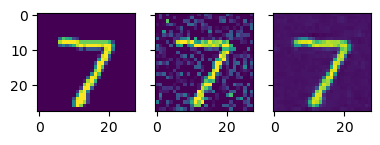

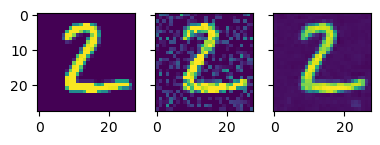

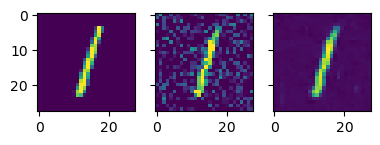

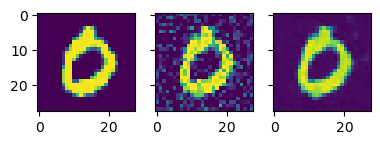

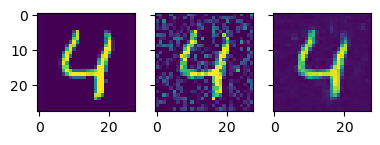

In [213]:
# Let's visualize a few examples:

Y, X = next(iter(test_dataloader))

Y_filtered = model(Y)
Y_filtered = Y_filtered.detach()

for i in range(5):
    
    fig, ax = plt.subplots(1, 3, sharey=True)
    ax[0].imshow(X[i, 0])  # clean
    ax[1].imshow(Y[i, 0])  # noisy
    ax[2].imshow(Y_filtered[i, 0])  # filtered

## Conclusion

In this notebook we have shown have filters can be learned to denoise images, and how using deep sequential networks of filters (CNN) can lead to even better denoising performance. 

For simplicity and for interpretability, we have chosen the output image of each layer to be of the same dimension as the input image (28x28, but with varying depth). In the next notebook(s), we will show how doing dimensionality reduction, by using pooling operators or different strides for example, can also help the network learn patterns and improve the denoising performance. This is the basic idea behing autoencoders.